In [1]:
%matplotlib inline

import cv2
import glob
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt

from scipy import misc


def cal_undistort(img, objpoints, imgpoints):
    """Helper function to undistort and image given a list of object points and image points"""
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
            objpoints, 
            imgpoints, 
            img.shape[:-1], 
            None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)


def draw_images(orig_img, modified_img, cmap=None, title1='Original Image', title2='Undistored Image'):
    """Helper function to draw side-by-side images"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    fig.tight_layout()
    
    ax1.imshow(orig_img, cmap=cmap)
    ax1.axis('off')
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(modified_img, cmap=cmap)
    ax2.axis('off')
    ax2.set_title(title2, fontsize=50)

Could not find corners: camera_cal/calibration1.jpg
Could not find corners: camera_cal/calibration4.jpg
Could not find corners: camera_cal/calibration5.jpg


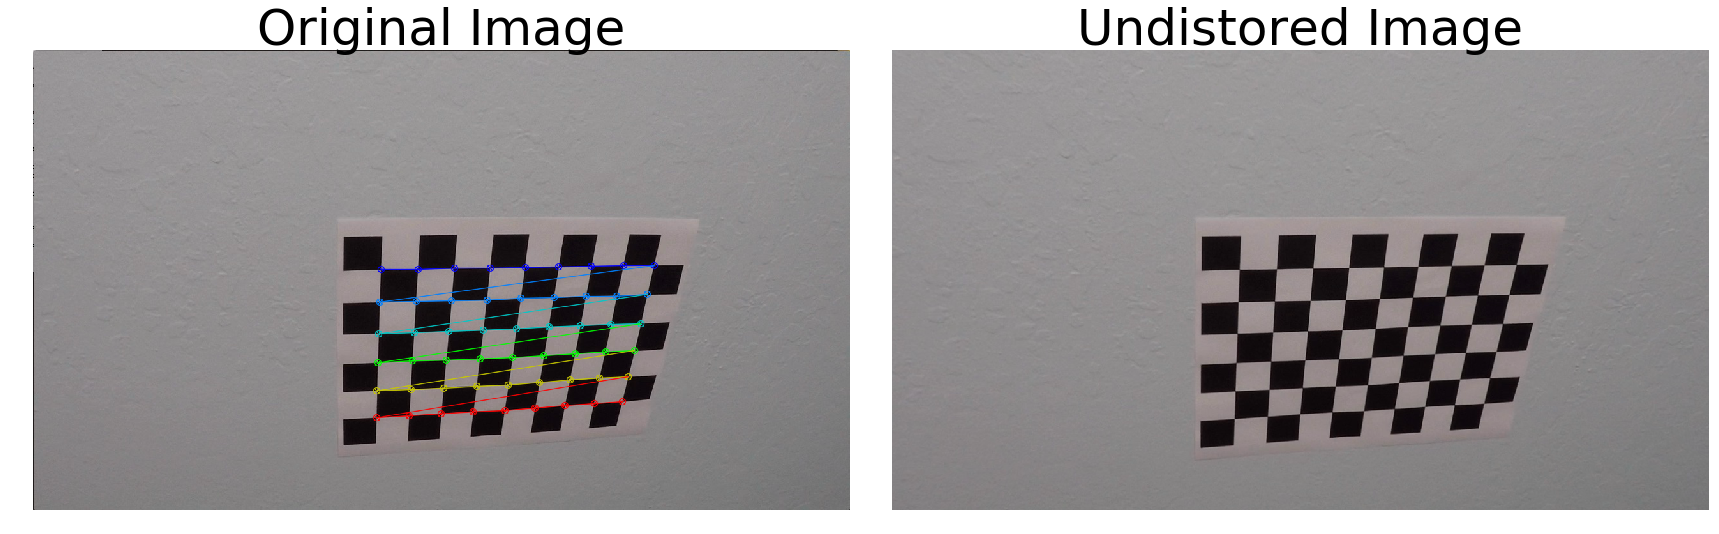

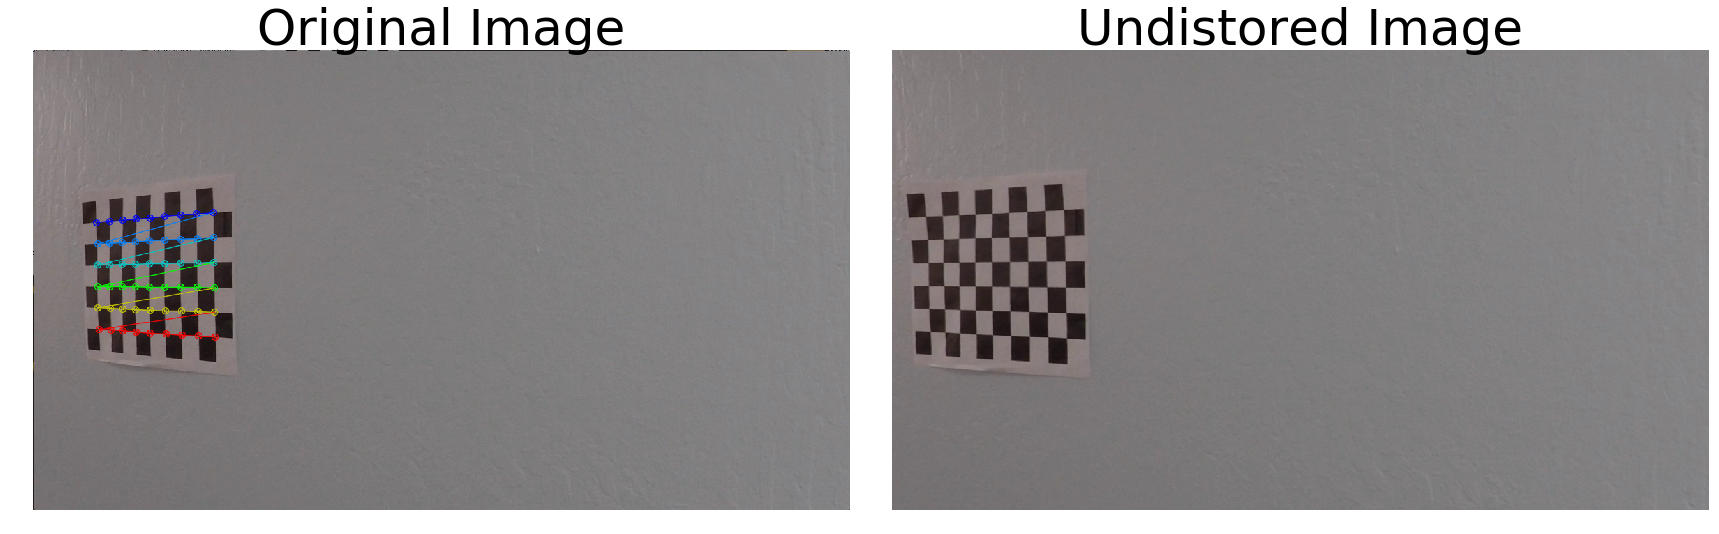

In [2]:
grid_size = (9, 6)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6 * 9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
corner_images = []

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
        
    # convert to grayscale and find the corners
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

    if not ret:
        print('Could not find corners: %s' % (fname, ))
        continue

    # If found, add object points, image points
    objpoints.append(objp)
    imgpoints.append(corners)
    
    corner_images.append((img, grid_size, corners, ret))

for i, (img, grids, corners, ret) in enumerate(corner_images[:2]):
    undistored_img = cal_undistort(img, objpoints, imgpoints)
    cv2.drawChessboardCorners(img, grid_size, corners, ret)
    draw_images(img, undistored_img)

# Apply distortion correction to raw test images

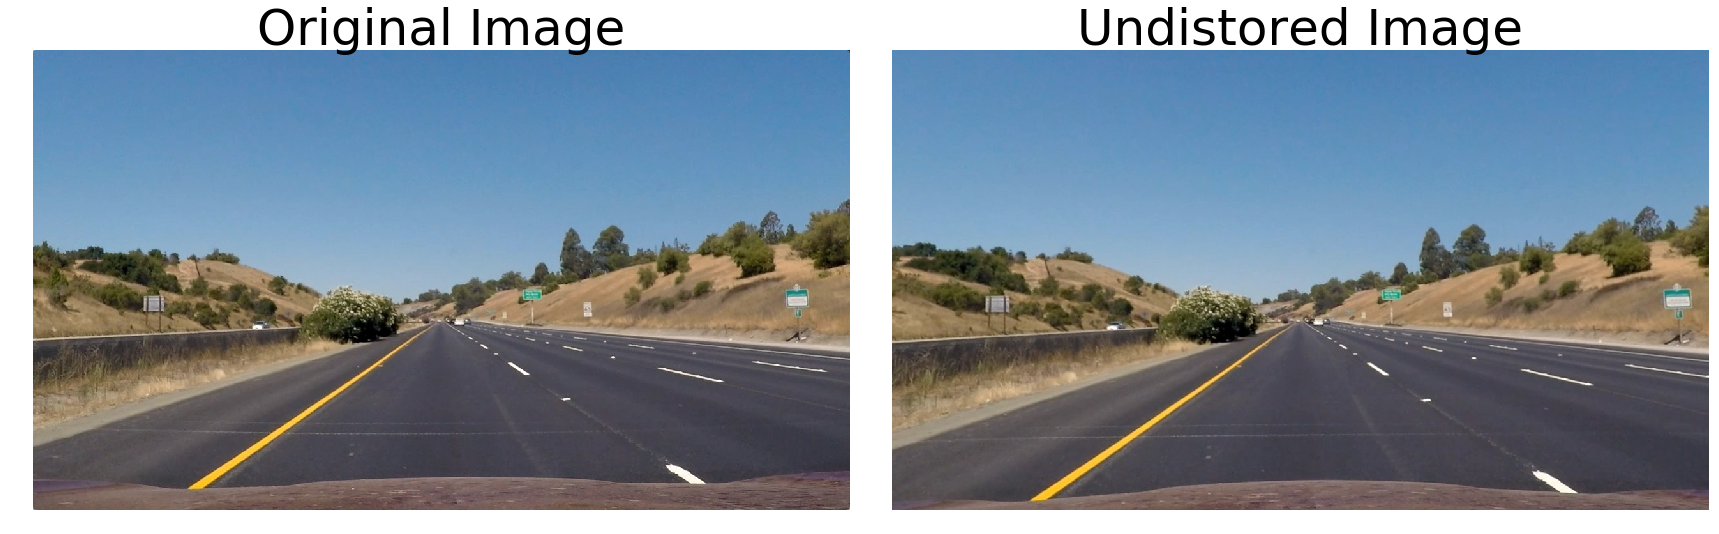

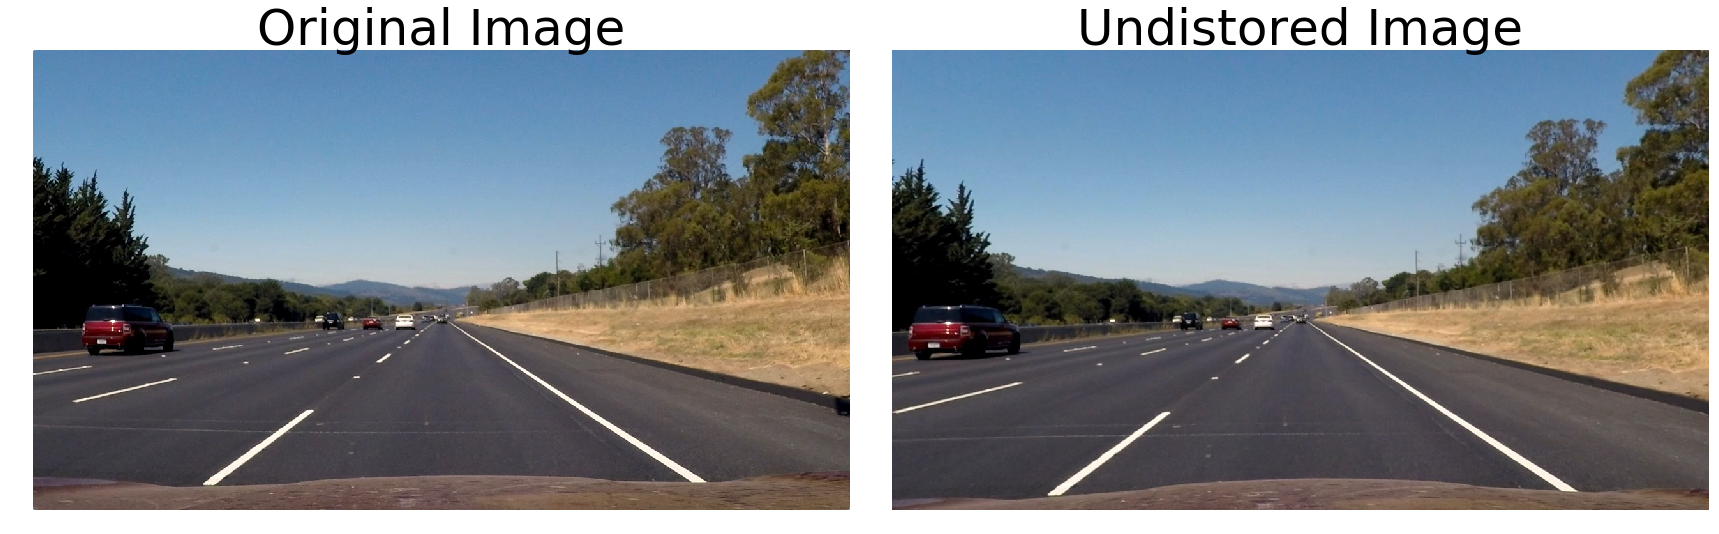

In [3]:
original_images = []
undistored_images = []

# Grab just a couple of imaged and validate
for fn in glob.glob('test_images/*.jpg')[:2]:
    img = misc.imread(fn)
    undistored_img = cal_undistort(img, objpoints, imgpoints)
    draw_images(img, undistored_img)
    original_images.append(img)
    undistored_images.append(undistored_img)

# Use color transforms, gradients, etc., to create a thresholded binary image.

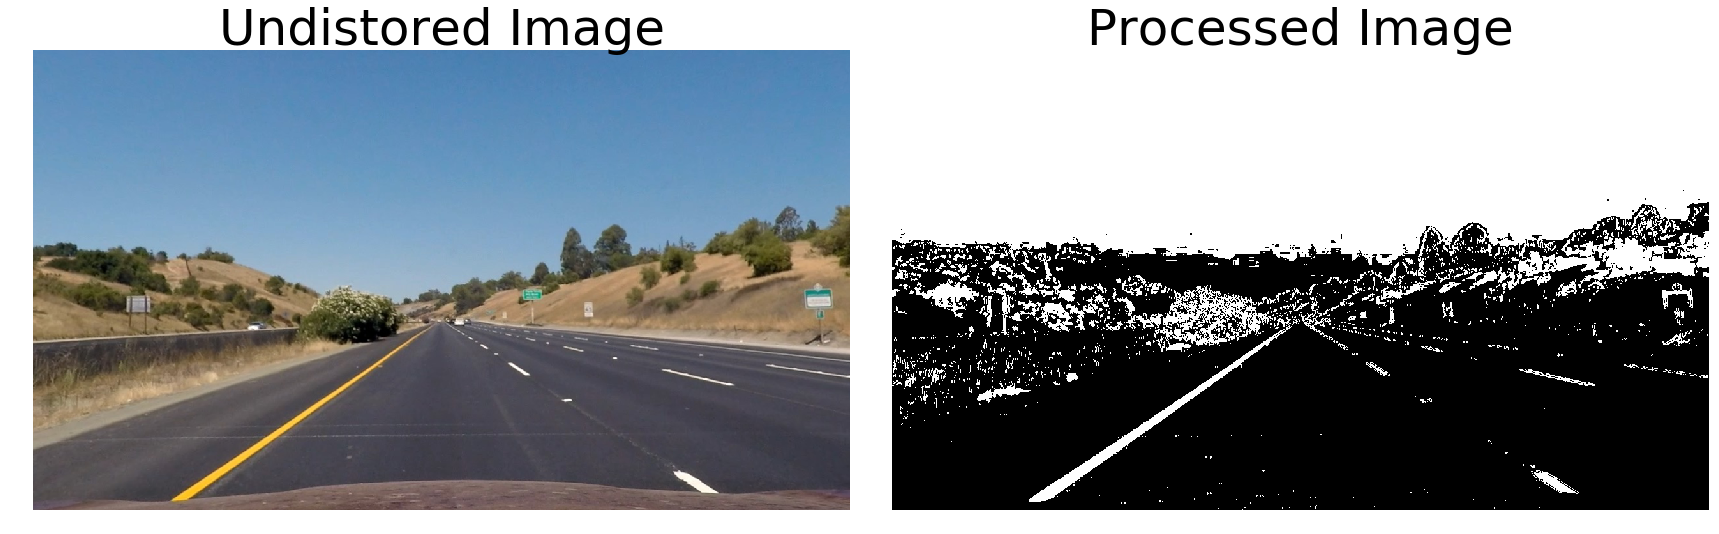

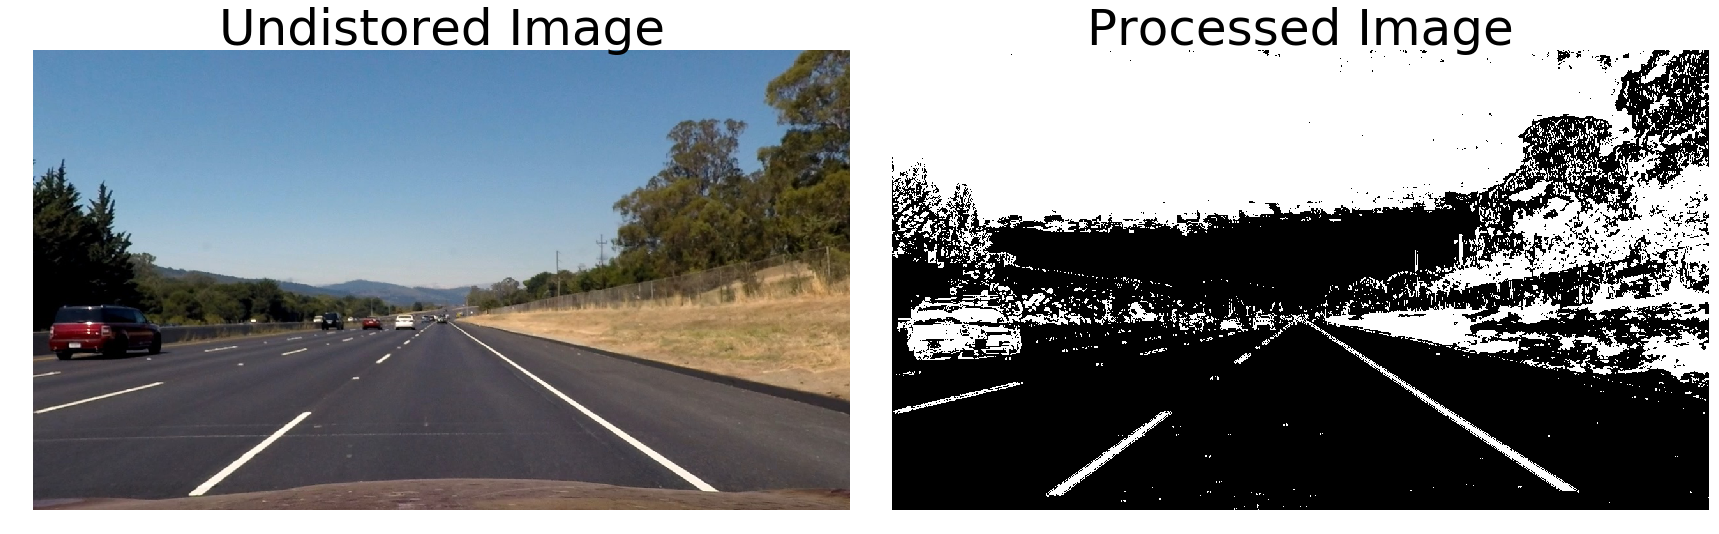

In [4]:
def pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[
        (s_channel > s_thresh[0])
        & (s_channel <= s_thresh[1])
    ] = 1

    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[
        (scaled_sobel >= sx_thresh[0]) 
        & (scaled_sobel <= sx_thresh[1])
    ] = 1
       
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    return combined_binary

processed_images = []

for img in undistored_images:
    new_image = pipeline(img)
    draw_images(img, 
                new_image, 
                title1='Undistored Image', 
                title2='Processed Image', 
                cmap='gray')
    processed_images.append(new_image)

# Apply a perspective transform to rectify binary image ("birds-eye view")

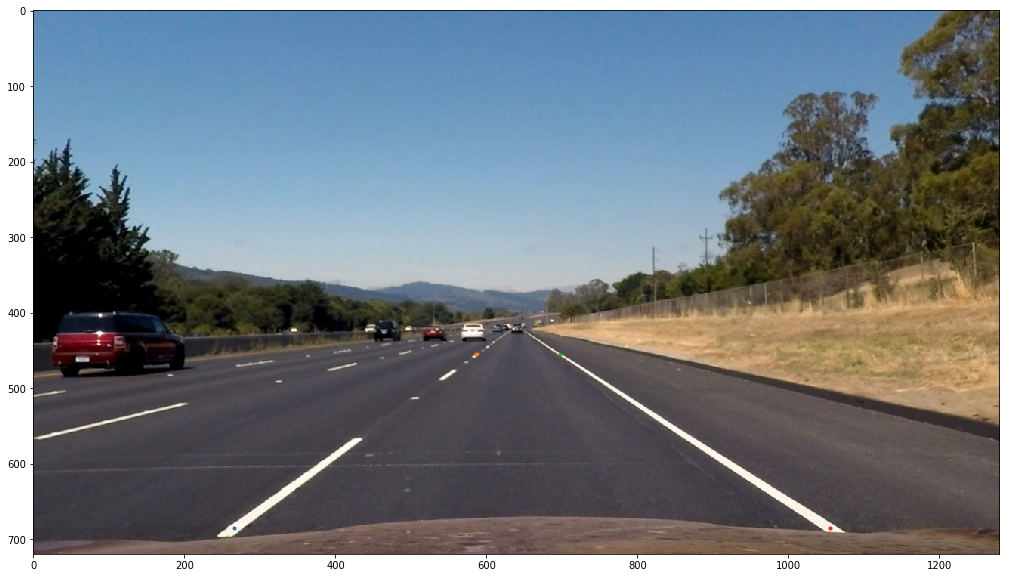

In [5]:
# Do some testing/marking to figure out where we want to choose points to transform

img = misc.imread('test_images/straight_lines2.jpg')
undistored_img = cal_undistort(img, objpoints, imgpoints)

shape = undistored_img.shape
h, w = shape[:2]

plt.figure(figsize=(24, 10))
plt.imshow(undistored_img)
src = np.float32([
    [265, 685], # bottom left
    [586, 455], # top left
    [698, 455], # top right
    [1055, 685], # bottom right
])
for x, y in src:
    plt.plot(x, y, '.')

plt.show()

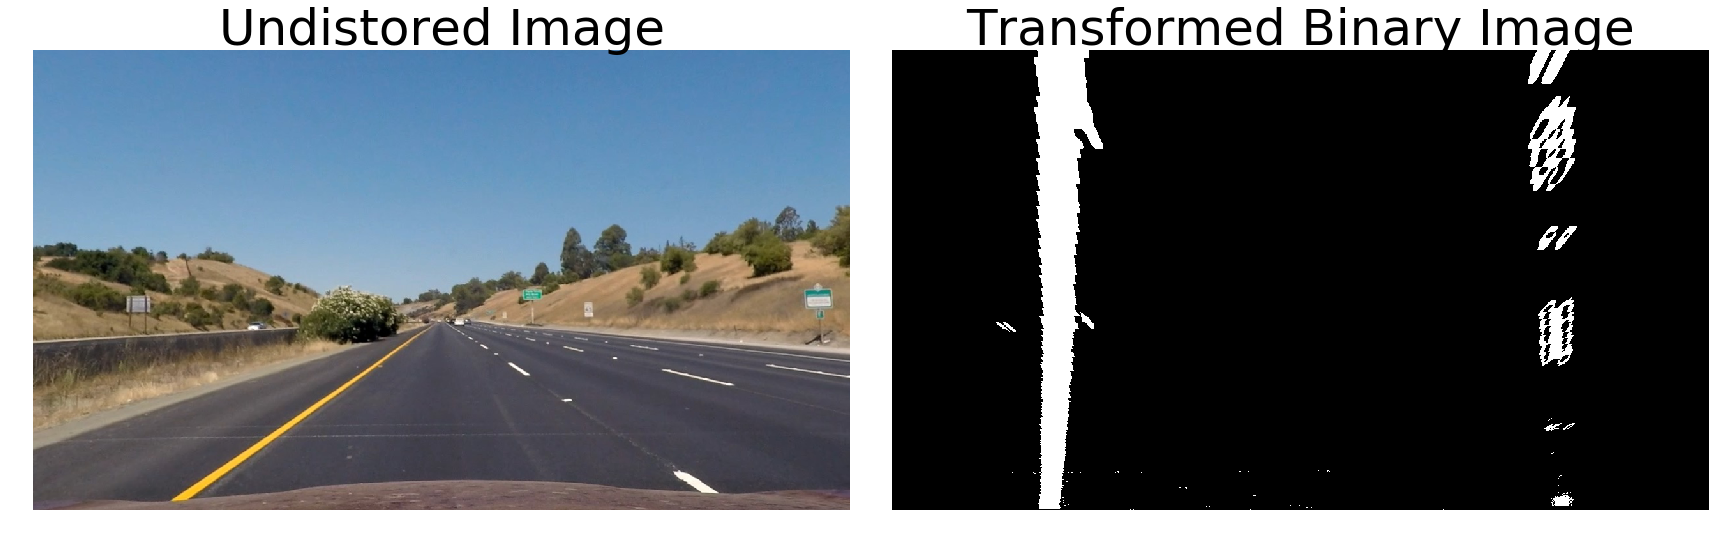

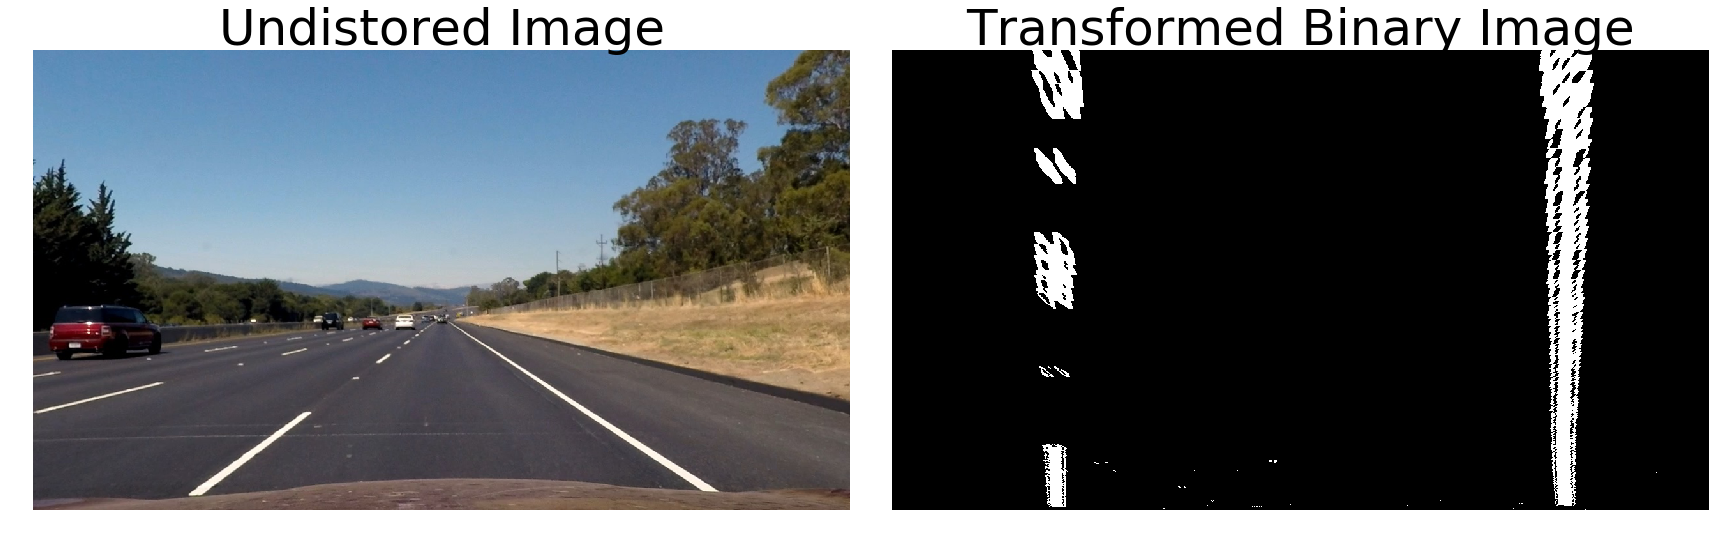

In [6]:
src = np.float32([
    [265, 685], # bottom left
    [586, 455], # top left
    [698, 455], # top right
    [1055, 685], # bottom right
])
dst = np.float32([
    [255, h - 10], # bottom left
    [245, 0], # top left
    [1065, 0], # top right
    [1055, h - 10], # bottom right
])

M = cv2.getPerspectiveTransform(src, dst)

transformed_binary_images = []

for i, img in enumerate(processed_images):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    draw_images(
        undistored_images[i], 
        warped, 
        title1='Undistored Image', 
        title2='Transformed Binary Image',
        cmap="gray")
    transformed_binary_images.append(warped)

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:123: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


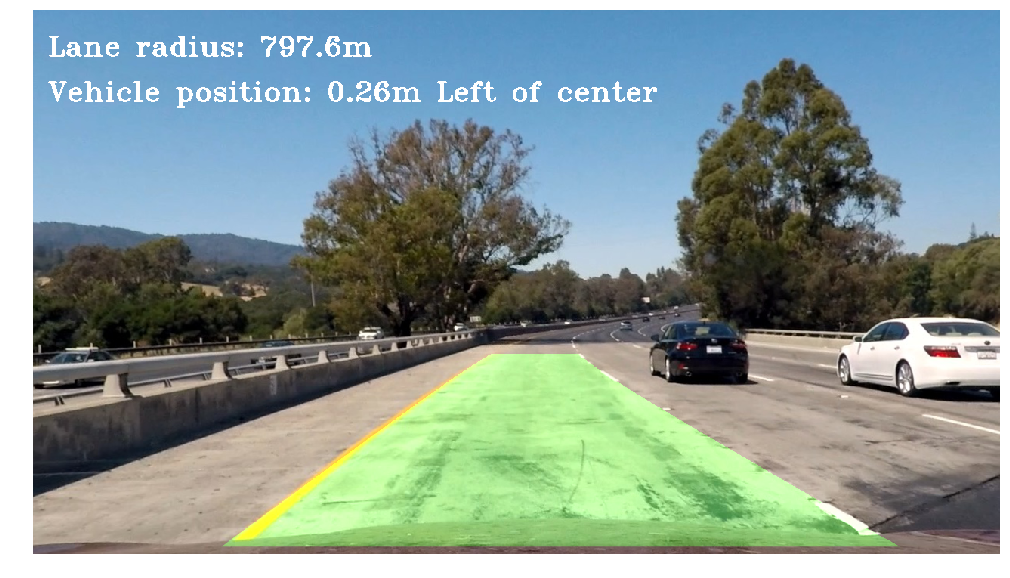

In [7]:
class Line:
    def __init__(self):
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #radius of curvature of the line in some units
        self.radius = None 


class LaneLineDetector:
    
    def __init__(self, img=None):
        if isinstance(img, (str, )):
            self._init_image_from_filename(img)
        elif img is not None:
            self._init_image(img)
            
        self._nwindows = 9
        
        # Set the width of the windows +/- margin
        self._window_margin = 100
        # Minimum number of non-zero pixels in a window required to recenter window
        self._minpix = 50
        
        # src and destination coordinates previously calculated for the perspective transform
        src = np.float32([
            [ 265, 685], # bottom left
            [ 586, 455], # top left
            [ 698, 455], # top right
            [1055, 685], # bottom right
        ])
        dst = np.float32([
            [ 255, 710],
            [ 245,   0],
            [1065,   0],
            [1055, 710],
        ])
        self._perspective_transform = cv2.getPerspectiveTransform(src, dst)
        self._perspective_transform_inverse = cv2.getPerspectiveTransform(dst, src)
        
        self.left_line = Line()
        self.right_line = Line()
            
    def _init_image(self, image):                                                                                                                                                           
        self._original_image = image
        
        # safely assume that we'll always be getting the same sized images when we're
        # using this in videos
        height = self._original_image.shape[0]
        width = self._original_image.shape[1] 
        
        # Generate x and y values for plotting
        self._ploty = np.linspace(0, height - 1, width)
        # Define y-value where we want radius of curvature
        self._y_eval = np.max(self._ploty)
        
    def _init_image_from_filename(self, fn):
        img = misc.imread(fn)
        self._init_image(img)
    
    def get_undistorted_image(self, img):
        return cal_undistort(img, objpoints, imgpoints)
    
    def threshold(self, img, s_thresh=(90, 255), sx_thresh=(20, 100)):
        """Create a binary image which is thresholded with a Sobel operatator on 
        the S channel in HLS color space.
        
        """
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        s_channel = hls[:,:,2]
        s_binary = np.zeros_like(s_channel)
        s_binary[
            (s_channel > s_thresh[0])
            & (s_channel <= s_thresh[1])
        ] = 1

        # Sobel x
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

        # Threshold x gradient
        sx_binary = np.zeros_like(scaled_sobel)
        sx_binary[
            (scaled_sobel >= sx_thresh[0]) 
            & (scaled_sobel <= sx_thresh[1])
        ] = 1
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sx_binary)
        combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
        return combined_binary

    def transform(self, img):
        img_size = (img.shape[1], img.shape[0])
        return cv2.warpPerspective(img, self._perspective_transform, img_size, flags=cv2.INTER_LINEAR)
    
    def _get_line_pixel_positions(self, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        return (leftx, lefty, rightx, righty)
    
    def _set_best_fits(self, leftx, lefty, rightx, righty):
        # Fit a second order polynomial to each
        self.left_line.best_fit = np.polyfit(lefty, leftx, 2)
        self.right_line.best_fit = np.polyfit(righty, rightx, 2)

    def _set_fitx(self):
        """From our previous polyfits, calulate x positions for the curve"""
        l1, l2, l3 = self.left_line.best_fit
        r1, r2, r3 = self.right_line.best_fit
        
        self.left_fitx = (l1 * self._ploty**2) + (l2 * self._ploty) + l3
        self.right_fitx = (r1 * self._ploty**2) + (r2 * self._ploty) + r3
        
    def init_polyfit(self, img):
        """Find the intial polynomial fits for the left and right lane lines"""
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[img.shape[0] / 2:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0] / 2)
        
        leftx_current = np.argmax(histogram[:midpoint])
        rightx_current = np.argmax(histogram[midpoint:]) + midpoint
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        window_height = np.int(img.shape[0] / self._nwindows)
    
        # Step through the windows one by one
        for window in range(self._nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window + 1) * window_height
            win_y_high = img.shape[0] - window * window_height
            win_xleft_low = leftx_current - self._window_margin
            win_xleft_high = leftx_current + self._window_margin
            win_xright_low = rightx_current - self._window_margin
            win_xright_high = rightx_current + self._window_margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = (
                (nonzeroy >= win_y_low) 
                & (nonzeroy < win_y_high) 
                & (nonzerox >= win_xleft_low) 
                & (nonzerox < win_xleft_high)
            ).nonzero()[0]
            good_right_inds = (
                (nonzeroy >= win_y_low) 
                & (nonzeroy < win_y_high) 
                & (nonzerox >= win_xright_low) 
                & (nonzerox < win_xright_high)
            ).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self._minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                
            if len(good_right_inds) > self._minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        self.leftx, self.lefty, self.rightx, self.righty = self._get_line_pixel_positions(
            nonzerox, nonzeroy, 
            left_lane_inds, right_lane_inds)

        self._set_best_fits(
            self.leftx, 
            self.lefty, 
            self.rightx, 
            self.righty,
        )
        self._set_fitx()
    
    def _get_lane_indices(self, line, nonzerox, nonzeroy, margin):
        # extract terms from our best fit polynomial
        t1, t2, t3 = line.best_fit 
        # Returns an array/generator of Bools which match the criteria below
        return (
            (nonzerox > \
             (t1 * (nonzeroy**2) + t2 * nonzeroy + t3 - margin)
            ) & 
            (nonzerox < 
             (t1 * (nonzeroy**2) + t2 * nonzeroy + t3 + margin))
        ) 
        
    def find_next_polyfit(self, binary_warped):
        """Find polynomial fits assuming we're already found them initially."""
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = self._get_lane_indices(
            self.left_line, 
            nonzerox, 
            nonzeroy, 
            self._window_margin
        )
        right_lane_inds = self._get_lane_indices(
            self.right_line, 
            nonzerox, 
            nonzeroy, 
            self._window_margin
        )
        self.leftx, self.lefty, self.rightx, self.righty = self._get_line_pixel_positions(
            nonzerox, nonzeroy, 
            left_lane_inds, right_lane_inds)

        self._set_best_fits(
            self.leftx, 
            self.lefty, 
            self.rightx, 
            self.righty,
        )
        self._set_fitx()
    
    def calculate_radius(self, binary_warped):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30 / 720 # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

        # Fit new polynomials to x, y in world space
        l1, l2, l3 = np.polyfit(self.lefty  * ym_per_pix, self.leftx  * xm_per_pix, 2)
        r1, r2, r3 = np.polyfit(self.righty * ym_per_pix, self.rightx * xm_per_pix, 2)

        # Calculate the new radii of curvature
        left_curverad =  ((1 + (2 * l1 * self._y_eval * ym_per_pix + l2)**2)**1.5) / np.absolute(2 * l1)
        right_curverad = ((1 + (2 * r1 * self._y_eval * ym_per_pix + r2)**2)**1.5) / np.absolute(2 * r1)
       
        # Now our radius of curvature is in meters
        return (left_curverad, right_curverad)

    def calculate_car_position(self, img):
        h, w = img.shape[:2]
        
        # Get the x positions for the left and right lane lines...at the very bottom of image
        l1, l2, l3 = self.left_line.best_fit
        r1, r2, r3 = self.right_line.best_fit
        leftx_int = l1 * h ** 2 + l2 * h + l3
        rightx_int = r1 * h ** 2 + r2 * h + r3
        
        # Figure out what we calculate in terms of the width of the lane at the bottom in pixels
        lane_width = (rightx_int - leftx_int)
        assert leftx_int < lane_width < rightx_int
        
        # now, this will represent where the center of the lane is...from the docs:
        #
        #  > the lane center is the midpoint at the bottom of the image between the two lines
        lane_center = leftx_int + (lane_width / 2)
        
        # > The offset of the lane center from the center of the image (converted from pixels to meters)
        # > is your distance from the center of the lane
        pos = 'Left' if (lane_center > w / 2) else 'Right'
        px_from_center = abs(w / 2 - lane_center)
 
        return (pos, px_from_center)

    def draw_region(self, binary_warped, image):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, self._ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, self._ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, 
                                      self._perspective_transform_inverse, 
                                      (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        return cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        
    def process_clip(self, image):
        self._init_image(image)                                                                                                                                                            
        return self.process()
    
    def process(self):
        undistorted = self.get_undistorted_image(self._original_image)
        
        # returns a 720,1280 binary image
        thresholded = self.threshold(undistorted)
        
        # now this is a 720,1280 birds eye view of the lane lines
        binary_warped = self.transform(thresholded)

        if self.left_line.best_fit is None:
            self.init_polyfit(binary_warped)
        else:
            self.find_next_polyfit(binary_warped)
        
        radius = self.calculate_radius(binary_warped)
        self.left_line.radius, self.right_line.radius = radius
        avg_radius = sum(radius) / 2

        final_img = self.draw_region(binary_warped, undistorted)
       
        text = "Lane radius: %0.1fm" % avg_radius
        cv2.putText(final_img, text , (20, 60), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (255,255,255), 2)
        
        pos, px_from_center = self.calculate_car_position(binary_warped)
        m_from_center = px_from_center * (3.7 / 700)
        text = "Vehicle position: %0.2fm %s of center" % (m_from_center, pos)
        cv2.putText(final_img, text , (20, 120), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (255,255,255), 2)

        return final_img


lld = LaneLineDetector(img='test_images/test1.jpg')
img = lld.process()
plt.figure(figsize=(24, 10))
plt.axis('off')
plt.imshow(img, cmap='gray')

In [ ]:
from moviepy.editor import VideoFileClip

input_fn = 'project_video.mp4'
if not os.path.isfile(input_fn):
    print('Fetching input video from S3...')
    urllib.urlretrieve('http://brianz-udacity-sdc.s3.amazonaws.com/p4/project_video.mp4', input_fn)
    
output_fn = 'output.mp4'
video_clip = VideoFileClip(input_fn)
processor = LaneLineDetector()
processor = video_clip.fl_image(processor.process_clip)
processor.write_videofile(output_fn, audio=False)